# 2D Poisson on a Ring

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/features/mindspore_poisson_ring.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/en/features/mindspore_poisson_ring.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_en/features/poisson_ring.ipynb)


## Overview

This tutorial describes how to use sympy to define the Dirichlet boundary conditions and the Neumann boundary conditions based on the two-dimensional Poisson problem and train a physical information neural network model. In this tutorial, you will learn:

- How to use sympy to define partial differential equation based on [MindFlow](https://mindspore.cn/mindflow/docs/zh-CN/master/index.html).

- How to define the Dirichlet boundary conditions and the Neumann boundary conditions in a model.

- How to train a physical information neural network using [MindSpore](https://mindspore.cn/docs/zh-CN/master/index.html) functional programming paradigm.

## Problem Description

Poisson's equation is an elliptic partial differential equation of broad utility in theoretical physics. For example, the solution to Poisson's equation is the potential field caused by a given electric charge or mass density distribution; with the potential field known, one can then calculate electrostatic or gravitational (force) field. We start from a 2-D homogeneous Poisson equation,

$$
f + \Delta u = 0
$$

where `u` is the primary variable, `f` is the source term, and $\Delta$ denotes the Laplacian operator.

We consider the source term `f` is given ($f=1.0$), then the form of Poisson' equation is as follows:

$$
\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2} + 1.0 = 0,
$$

In this case, the Dirichlet boundary condition and the Neumann boundary condition are used. The format is as follows:

Dirichlet boundary condition on the boundary of outside circle:

$$
u = 0
$$

Neumann boundary condition on the boundary of inside circle：

$$
du/dn = 0
$$

In this case, the PINNs method is used to learn the mapping $(x, y) \mapsto u$. So that the solution of Poisson' equation is realized.


## Technology Path

MindFlow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. Poisson2D.
5. Model Training.
6. Model Evaluation and Visualization.

### Importing the required packages

In this tutorial, you will make use of [Disk](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#mindflow.geometry.Disk) and [CSGXOR](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#mindflow.geometry.CSGXOR) to make a geometry with input and output boundaries, as well as domain. You will use sympy to define boundary condition and governing equations based on [Poisson](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.pde.html#mindflow.pde.Poisson). You will use [MultiScaleFCCell](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.cell.html#mindflow.cell.MultiScaleFCCell) to construct a network. `Disk` and `CSGXOR` are imported from `MindFlow` [geometry](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.geometry.html#) module. `Poisson` is imported from `MindFlow` [pde](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.pde.html) module. `MultiScaleFCCell` is imported from `MindFlow` [cell](https://mindspore.cn/mindflow/docs/zh-CN/master/mindflow.cell.html) module. The above modules together constitute a model for solving the two-dimensional poisson problem.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import symbols, Function, diff

import mindspore as ms
from mindspore import nn, ops, Tensor, set_context, set_seed, jit
from mindspore import dtype as mstype

from mindflow.pde import Poisson, sympy_to_mindspore
from mindflow.cell import MultiScaleFCCell
from mindflow.geometry import generate_sampling_config, Disk, CSGXOR


set_seed(123456)
set_context(mode=ms.GRAPH_MODE, device_target="GPU", device_id=0)


## Training Dataset Construction

In this case, random sampling is performed according to the solution domain, initial condition and boundary value condition to generate training data sets. The specific settings are as follows. Download data construction [Python script](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/poisson_ring/src/dataset.py).

In [2]:
class MyIterable:
    def __init__(self, domain, bc_outer, bc_inner, bc_inner_normal):
        self._index = 0
        self._domain = domain.astype(np.float32)
        self._bc_outer = bc_outer.astype(np.float32)
        self._bc_inner = bc_inner.astype(np.float32)
        self._bc_inner_normal = bc_inner_normal.astype(np.float32)

    def __next__(self):
        if self._index >= len(self._domain):
            raise StopIteration

        item = (self._domain[self._index], self._bc_outer[self._index], self._bc_inner[self._index],
                self._bc_inner_normal[self._index])
        self._index += 1
        return item

    def __iter__(self):
        self._index = 0
        return self

    def __len__(self):
        return len(self._domain)


def _get_region(config):
    indisk_cfg = config["in_disk"]
    in_disk = Disk(indisk_cfg["name"], (indisk_cfg["center_x"], indisk_cfg["center_y"]), indisk_cfg["radius"])
    outdisk_cfg = config["out_disk"]
    out_disk = Disk(outdisk_cfg["name"], (outdisk_cfg["center_x"], outdisk_cfg["center_y"]), outdisk_cfg["radius"])
    union = CSGXOR(out_disk, in_disk)
    return in_disk, out_disk, union


def create_training_dataset(config):
    '''create_training_dataset'''
    in_disk, out_disk, union = _get_region(config)

    union.set_sampling_config(generate_sampling_config(config["data"]))
    domain = union.sampling(geom_type="domain")

    out_disk.set_sampling_config(generate_sampling_config(config["data"]))
    bc_outer, _ = out_disk.sampling(geom_type="BC")

    in_disk.set_sampling_config(generate_sampling_config(config["data"]))
    bc_inner, bc_inner_normal = in_disk.sampling(geom_type="BC")

    dataset = ms.dataset.GeneratorDataset(source=MyIterable(domain, bc_outer, bc_inner, (-1.0) * bc_inner_normal),
                                          column_names=["data", "bc_outer", "bc_inner", "bc_inner_normal"])
    return dataset


def _calcu_color(x, y):
    return (4.0 - x ** 2 - y ** 2) / 4


def create_test_dataset(config):
    """create test dataset"""
    _, _, union = _get_region(config)
    union.set_sampling_config(generate_sampling_config(config["data"]))
    test_data = union.sampling(geom_type="domain")
    test_label = _calcu_color(test_data[:, 0], test_data[:, 1]).reshape(-1, 1)
    return test_data, test_label


The geometric shape of the generated data is a ring, the radius of the inner circle is 1.0, the radius of the outer circle is 2.0, and the amount of data in the boundary and domain is 8192. The generation parameters are set as follows:

In [3]:
in_disk = {"name": "in_disk", "center_x": 0.0, "center_y": 0.0, "radius": 1.0}
out_disk = {"name": "out_disk", "center_x": 0.0, "center_y": 0.0, "radius": 2.0}
domain = {"size": 8192, "random_sampling": True, "sampler": "uniform"}
BC = {"size": 8192, "random_sampling": True, "sampler": "uniform", "with_normal": True}
data = {"domain": domain, "BC": BC}
config = {"in_disk": in_disk, "out_disk": out_disk, "data": data}

# create training dataset
dataset = create_training_dataset(config)
train_dataset = dataset.batch(batch_size=8192)

# create test dataset
inputs, label = create_test_dataset(config)

## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [4]:
model = MultiScaleFCCell(in_channels=2,
                         out_channels=1,
                         layers=6,
                         neurons=128,
                         residual=False,
                         act="tanh",
                         num_scales=1)

## Optimizer

Using Adaptive Moment Estimation (Adam) optimizer.

In [5]:
optimizer = nn.Adam(model.trainable_params(), 0.001)


## Poisson2D

The following `Poisson2D` includes the governing equations, Dirichlet boundary conditions, Norman boundary conditions, etc. The `sympy` is used for delineating partial differential equations in symbolic forms and computing all equations' loss.

### Symbol Declaration

Define `x`, `y`, and `n` to indicate the the horizontal coordinate, vertical coordinate, and normal vectors of inner circle boundary, respectively. The output `u` is a function related to `x` and `y`.

In [6]:
x, y, n = symbols('x y n')
u = Function('u')(x, y)

# independent variables
in_vars = [x, y]
print("independent variables: ", in_vars)

# dependent variables
out_vars = [u]
print("dependent variables: ", out_vars)

independent variables:  [x, y]
dependent variables:  [u(x, y)]


### Governing Equations

In [7]:
govern_eq = diff(u, (x, 2)) + diff(u, (y, 2)) + 1.0
print("governing equation: ", govern_eq)

governing equation:  Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0


### Dirichlet Boundary Condition

In [8]:
bc_outer = u
print("bc_outer equation: ", bc_outer)

bc_outer equation:  u(x, y)


### Neumann Boundary Condition

In [9]:
bc_inner = sympy.Derivative(u, n) - 0.5
print("bc_inner equation: ", bc_inner)

bc_inner equation:  Derivative(u(x, y), n) - 0.5


The following `Poisson2D` problem is defined based on the `Poisson` base class combined with the governing equations and boundary conditions defined above. Download `Poisson2D` [Python script](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/poisson_ring/src/model.py).

In [10]:
class Poisson2D(Poisson):
    def __init__(self, model, loss_fn="mse"):
        super(Poisson2D, self).__init__(model, loss_fn=loss_fn)
        self.bc_outer_nodes = sympy_to_mindspore(self.bc_outer(), self.in_vars, self.out_vars)
        self.bc_inner_nodes = sympy_to_mindspore(self.bc_inner(), self.in_vars, self.out_vars)

    def bc_outer(self):
        bc_outer_eq = self.u
        equations = {"bc_outer": bc_outer_eq}
        return equations

    def bc_inner(self):
        bc_inner_eq = sympy.Derivative(self.u, self.normal) - 0.5
        equations = {"bc_inner": bc_inner_eq}
        return equations

    def get_loss(self, pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_inner_res = self.parse_node(self.bc_inner_nodes, inputs=bc_inner_data, norm=bc_inner_normal)
        bc_inner_loss = self.loss_fn(bc_inner_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_outer_res = self.parse_node(self.bc_outer_nodes, inputs=bc_outer_data)
        bc_outer_loss = self.loss_fn(bc_outer_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + bc_inner_loss + bc_outer_loss

problem = Poisson2D(model)

poisson: Derivative(u(x, y), (x, 2)) + Derivative(u(x, y), (y, 2)) + 1.0
    Item numbers of current derivative formula nodes: 3
bc_outer: u(x, y)
    Item numbers of current derivative formula nodes: 1
bc_inner: Derivative(u(x, y), n) - 0.5
    Item numbers of current derivative formula nodes: 2


## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks. Download training [Python script](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/poisson_ring/train.py).

In [11]:
# define forward function
def forward_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
    loss = problem.get_loss(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
    return loss

# define grad function
grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

# using jit to accelerate training
@jit
def train_step(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal):
    loss, grads = grad_fn(pde_data, bc_outer_data, bc_inner_data, bc_inner_normal)
    loss = ops.depend(loss, optimizer(grads))
    return loss


Download the calculate function of training process in [Python script](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/poisson_ring/src/utils.py).

In [12]:
def _calculate_error(label, prediction):
    '''calculate l2-error to evaluate accuracy'''
    error = label - prediction
    l2_error = np.sqrt(np.sum(np.square(error[..., 0]))) / np.sqrt(np.sum(np.square(label[..., 0])))

    return l2_error


def _get_prediction(model, inputs, label_shape, batch_size):
    '''calculate the prediction respect to the given inputs'''
    prediction = np.zeros(label_shape)
    prediction = prediction.reshape((-1, label_shape[1]))
    inputs = inputs.reshape((-1, inputs.shape[1]))

    time_beg = time.time()

    index = 0
    while index < inputs.shape[0]:
        index_end = min(index + batch_size, inputs.shape[0])
        test_batch = Tensor(inputs[index: index_end, :], mstype.float32)
        prediction[index: index_end, :] = model(test_batch).asnumpy()
        index = index_end

    print("    predict total time: {} ms".format((time.time() - time_beg) * 1000))
    prediction = prediction.reshape(label_shape)
    prediction = prediction.reshape((-1, label_shape[1]))
    return prediction


def calculate_l2_error(model, inputs, label, batch_size):
    label_shape = label.shape
    prediction = _get_prediction(model, inputs, label_shape, batch_size)
    label = label.reshape((-1, label_shape[1]))
    l2_error = _calculate_error(label, prediction)
    print("    l2_error: ", l2_error)
    print("==================================================================================================")


In [13]:
epochs = 5000
steps_per_epochs = train_dataset.get_dataset_size()
sink_process = ms.data_sink(train_step, train_dataset, sink_size=1)

for epoch in range(1, epochs + 1):
    # train
    time_beg = time.time()
    model.set_train(True)
    for _ in range(steps_per_epochs):
        step_train_loss = sink_process()
    print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
    model.set_train(False)
    if epoch % 100 == 0:
        # eval
        calculate_l2_error(model, inputs, label, 8192)

epoch: 1 train loss: 1.2577767 epoch time: 6024.162 ms
epoch: 2 train loss: 1.2554792 epoch time: 70.884 ms
epoch: 3 train loss: 1.2534575 epoch time: 71.048 ms
epoch: 4 train loss: 1.2516733 epoch time: 100.632 ms
epoch: 5 train loss: 1.2503157 epoch time: 65.656 ms
epoch: 6 train loss: 1.2501826 epoch time: 137.487 ms
epoch: 7 train loss: 1.2511331 epoch time: 51.191 ms
epoch: 8 train loss: 1.2508672 epoch time: 65.980 ms
epoch: 9 train loss: 1.2503275 epoch time: 211.144 ms
epoch: 10 train loss: 1.2500556 epoch time: 224.515 ms
epoch: 11 train loss: 1.2500004 epoch time: 225.964 ms
epoch: 12 train loss: 1.2500298 epoch time: 220.117 ms
epoch: 13 train loss: 1.2500703 epoch time: 221.441 ms
epoch: 14 train loss: 1.2500948 epoch time: 220.214 ms
epoch: 15 train loss: 1.2500978 epoch time: 219.836 ms
epoch: 16 train loss: 1.250083 epoch time: 220.141 ms
epoch: 17 train loss: 1.2500567 epoch time: 229.682 ms
epoch: 18 train loss: 1.2500263 epoch time: 216.013 ms
epoch: 19 train loss: 1.

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized. Download visulization [Python script](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/features/poisson_ring/src/utils.py).

In [14]:
def visual(model, inputs, label, epochs=1):
    '''visual result for poisson 2D'''
    fig, ax = plt.subplots(2, 1)
    ax = ax.flatten()
    plt.subplots_adjust(hspace=0.5)
    ax0 = ax[0].scatter(inputs[:, 0], inputs[:, 1], c=label[:, 0], cmap=plt.cm.rainbow, s=0.5)
    ax[0].set_title("true")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].axis('equal')
    ax[1].scatter(inputs[:, 0], inputs[:, 1], c=model(Tensor(inputs, mstype.float32)), cmap=plt.cm.rainbow, s=0.5)
    ax[1].set_title("prediction")
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].axis('equal')
    cbar = fig.colorbar(ax0, ax=[ax[0], ax[1]])
    cbar.set_label('u(x, y)')

    plt.savefig(f"images/{epochs}-result.jpg", dpi=600)


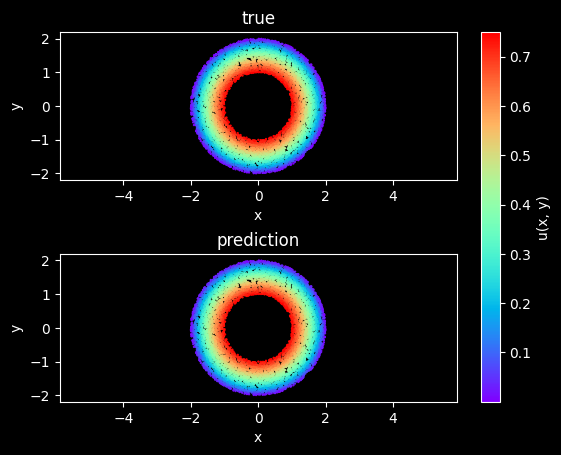

In [15]:
# visualization
visual(model, inputs, label, 5000)